In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
from utils import *
from kernel_sca_inducing_points import *
from kernels import *
import plotly.graph_objs as go
import plotly.express as px 

In [2]:

directory_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/PSTHs'

files = [f for f in os.listdir(directory_path) if 'DotsOn_Leader' in f]

PSTHs = []
for file in files:
    try:
        mat_data = scipy.io.loadmat(f'{directory_path}/{file}')    
        PSTHs.append(np.vstack(mat_data['DotsOn'].squeeze()))
    except Exception as e:
        print(f"Error processing {file}: {e}")

PSTHs = np.stack(PSTHs)

Error processing DotsOn_Leader_1_22.mat: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 26 and the array at index 5 has size 1


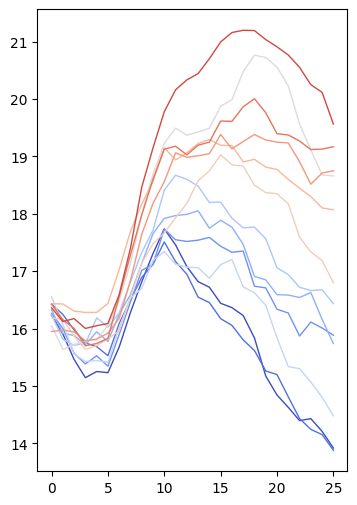

In [11]:
test = np.mean(PSTHs, axis=0)
K, T = test.shape

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
cmap = plt.cm.coolwarm
for k in range(K):
    x = test[k, :]
    color = cmap(k / K)
    ax.plot(x, linestyle='-', linewidth=1, color=color) #marker='.'

In [4]:
X = PSTHs.swapaxes(0,1)
X, _ = pre_processing(X, pca=False, center=False)

K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)  



In [5]:
d = 2
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.011942005716264248, S_ratio: 0.19209791719913483
Iteration 10, S: 0.17275011539459229, S_ratio: 0.4792613089084625
Iteration 20, S: 0.35692304372787476, S_ratio: 0.5498465299606323
Iteration 30, S: 0.5236379504203796, S_ratio: 0.4619733393192291
Iteration 40, S: 0.5251472592353821, S_ratio: 0.38202908635139465
Iteration 50, S: 0.5322772264480591, S_ratio: 0.3637239336967468
Iteration 60, S: 0.6020684242248535, S_ratio: 0.3667190670967102
Iteration 70, S: 0.7450602054595947, S_ratio: 0.3787773549556732
Iteration 80, S: 0.6112565994262695, S_ratio: 0.3730451166629791
Iteration 90, S: 0.7304637432098389, S_ratio: 0.3497717082500458
Iteration 100, S: 0.7767783403396606, S_ratio: 0.36274453997612
Iteration 110, S: 0.778948187828064, S_ratio: 0.3999466300010681
Iteration 120, S: 0.7695756554603577, S_ratio: 0.37695571780204773
Iteration 130, S: 0.7406839728355408, S_ratio: 0.37418755888938904
Iteration 140, S: 0.7008706331253052, S_ratio: 0.3826686143875122
Iteration 150, S

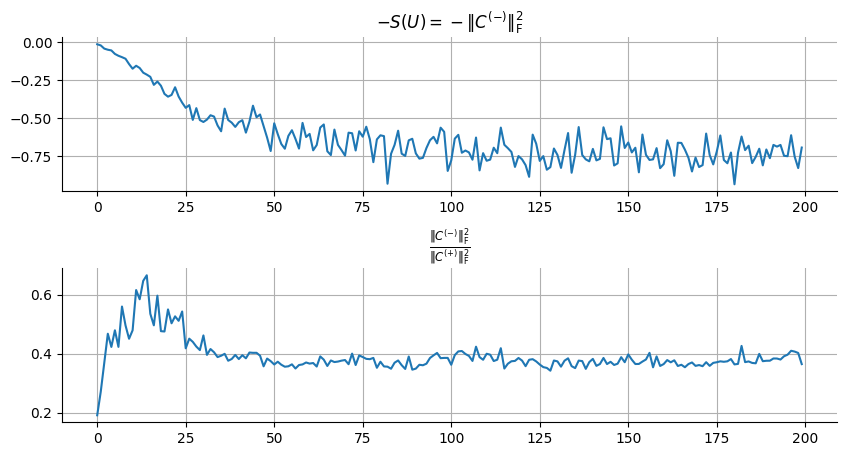

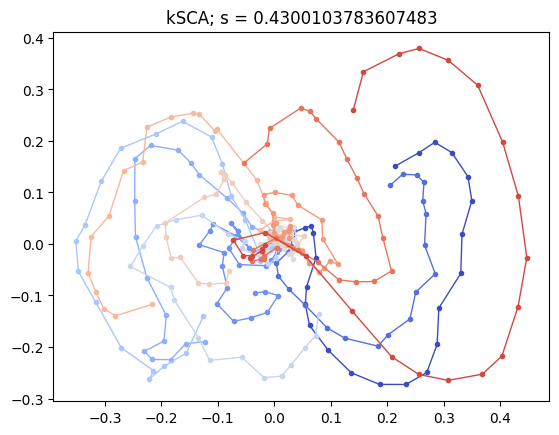

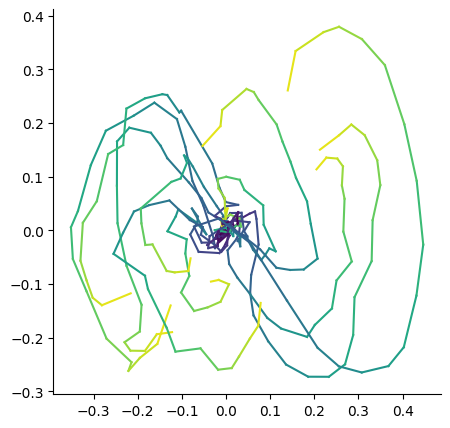

In [10]:
get_loss_fig(ls_loss, ls_S_ratio)

_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u , _ = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111) #, projection='3d'
cmap = plt.cm.coolwarm
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    #z = Y[k, 2, :] 
    color = cmap(k / K)
    #ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)
    ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)

plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_2D(Y[:,:,:])

ENDS HERE 

In [59]:
def get_PSTH(epoch):
    config_rf_ls = ['Ar', 'Ag', 'Br', 'Bg']
    leaders = []
    supporters = []
    for config_rf in config_rf_ls:
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Leaders/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            leaders.append(np.vstack(data[i]))
        
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Supporters/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            supporters.append(np.vstack(data[i]))
        
        
    return np.stack(leaders), np.stack(supporters), np.concatenate((leaders, supporters))


DotsOnleaders, DotsOnsupporters, DotsOn = get_PSTH('DotsOn')
LibSaccleaders, _,LibSacc = get_PSTH('LibSacc')
Slibleaders, _,Slib = get_PSTH('Slib')
LastFixleaders, _,LastFix = get_PSTH('LastFix')
ChoiceSaccleaders, _,ChoiceSacc = get_PSTH('ChoiceSacc')
#X = np.concatenate((DotsOn, LibSacc, Slib, LastFix, ChoiceSacc), axis=2).swapaxes(0,1)

X = DotsOnleaders.swapaxes(0,1)
X, _ = pre_processing(X, soft_normalize='max', center=False)

K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)  

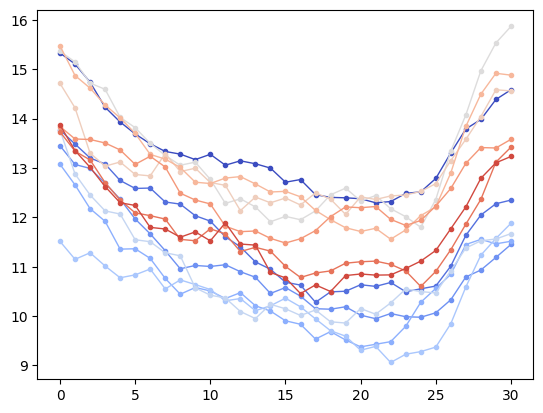

In [60]:
test = np.mean(Slibleaders, axis=0)


fig = plt.figure()
ax = fig.add_subplot(111)
cmap = plt.cm.coolwarm
for k in range(K):
    x = test[k, :]
    color = cmap(k / K)
    ax.plot(x, linestyle='-', marker='.', linewidth=1, color=color)

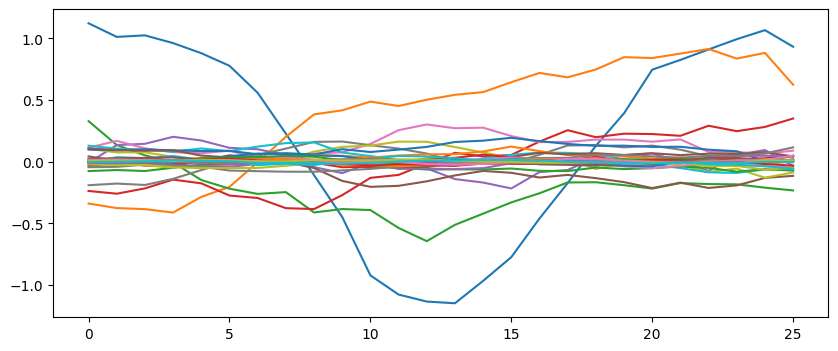

In [40]:
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.plot( X[-1,i,:] )

In [44]:
d = 3
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=300, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 0.12300030142068863, S_ratio: 0.28914734721183777
Iteration 10, S: 1.6175727844238281, S_ratio: 0.42559000849723816
Iteration 20, S: 2.4604969024658203, S_ratio: 0.41436976194381714
Iteration 30, S: 3.698974609375, S_ratio: 0.4353656470775604
Iteration 40, S: 3.9174482822418213, S_ratio: 0.47230497002601624
Iteration 50, S: 5.476383686065674, S_ratio: 0.4666591286659241
Iteration 60, S: 5.450364589691162, S_ratio: 0.4367104768753052
Iteration 70, S: 4.200277805328369, S_ratio: 0.447202205657959
Iteration 80, S: 5.232303619384766, S_ratio: 0.4619538486003876
Iteration 90, S: 5.9028215408325195, S_ratio: 0.44762858748435974
Iteration 100, S: 3.2664928436279297, S_ratio: 0.5136421322822571
Iteration 110, S: 5.447988986968994, S_ratio: 0.47994545102119446
Iteration 120, S: 6.7290778160095215, S_ratio: 0.45153123140335083
Iteration 130, S: 5.08828592300415, S_ratio: 0.4366876482963562
Iteration 140, S: 5.983179092407227, S_ratio: 0.44717586040496826
Iteration 150, S: 5.18378

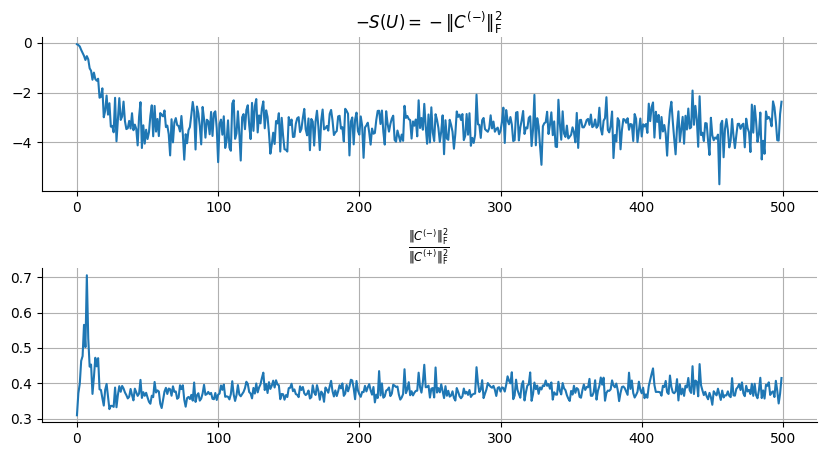

In [42]:
get_loss_fig(ls_loss, ls_S_ratio)

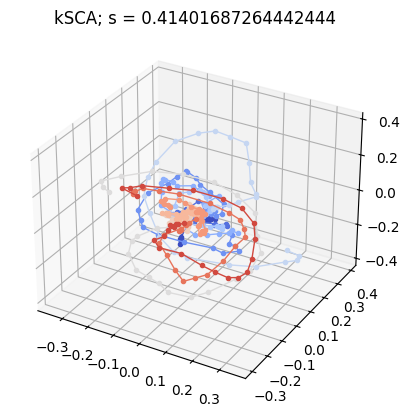

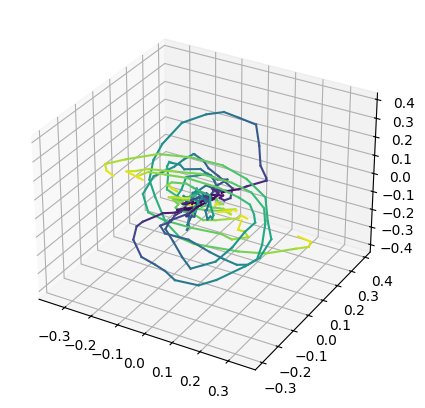

In [22]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u , _ = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.coolwarm
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :] 
    color = cmap(k / K)
    ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)
    #ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)

plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_3D(Y[:,:,:])

In [43]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()